# Playing Mountain Car Using Actor-Critic Method

---

Here we will consider methods that learn a parameterized policy that can select actions by consulting a value function as a critic. Note that different from before, here we use

- **function approximation(FA)**, to approximate the Q_table when the state space is large that we cannot store Q for all the states.
- **learned policy to select action**, now action is no longer selected by $\mathop{\arg\max}_{a\in \mathcal{A}} Q(s,a)$, but selected by consulting the parameterized policy $\pi(a|s,\theta) = Pr(A_t=a|S_t=s, \theta_t=\theta)$

In some kinds of policy gradient(PG) methods, a value function may still be used to *help to learn* the policy parameter, but is not required for action selection. In this notebook, if a method uses a learned value function as well, then the value function's weight parameter is denoted by $w$, as in $v(s,w)$ for the parameterized value function, to diffentiate from $\pi(a|s,\theta)$.

## Why Use Policy-based Method?

- The best approximate policy may be stochastic, like Poker which is in imperfect information.
- The policy may have a simpler function to approximate.
- Can be used for continuous control problem.

## Representation of Policy in Policy Approximation

Policy can be parameterized in any way, as long as $\pi(a|s, \theta)$ is differentiable with respect to its parameters, i.e. $\nabla_\theta \pi(a|s, \theta)$ exists and is always finite. If the action space is discrete and not too large, then a natural kind of parameterization is to form parameterized numerical preferences $h(s,a, \theta)\in \mathbb{R}$ for each state-action pair. The preference could simply be linear in features,

$$h(s,a, \theta) = \theta^Tx(s,a)$$

or by using more complex neural network. Then the policy can be represented in a softmax way to become a probability distribution,

$$\pi(a|s, \theta) = \frac{exp(h(s,a,\theta))}{\sum_b exp(h(s,b,\theta))}$$

## Policy Gradient Theorem (for the episodic case)

To make our policy better and better, a performance measurement should be defined to gain the gradient of the policy. In episodic case we can define performance as the true value of initial state under policy $\theta$ 

$$J(\theta) \doteq v_{\pi_\theta}(s_0)$$

To simplify the equations, all $\nabla$ later refers to $\nabla_\theta$ and $\pi$ refers to $\pi_\theta$, and we will assume no discounting ($\gamma=1$). The policy gradient theorem establishes that

$$\nabla J(\theta) \propto \sum_s \mu(s) \sum_a q_\pi(s,a) \nabla_\theta\pi(a|s,\theta)$$

where $\mu(s)$ is the state distribution under policy $\pi$. Proof can be seen at the end of the notebook.

## From REINFORCE to Actor-Critic

**REINFORCE** (Monte-Carlo policy gradient) relies on an estimated return by Monte-Carlo methods using episode samples to update the policy parameter $\theta$.

$$\begin{aligned}
\nabla J(\theta) &\propto \sum_s \mu(s) \sum_a q_\pi(s,a) \nabla_\theta\pi(a|s,\theta)
\\& = \mathbb E_\pi \left[ \sum_a q_\pi(S_t,a) \nabla_\theta\pi(a|S_t,\theta) \right]
\\& = \mathbb E_\pi \left[ \sum_a \pi(a|S_t,\theta) q_\pi(S_t,a) \frac{\nabla_\theta\pi(a|S_t,\theta)}{\pi(a|S_t,\theta)} \right]
\\& = \mathbb E_\pi \left[ q_\pi(S_t,A_t) \frac{\nabla_\theta\pi(A_t|S_t,\theta)}{\pi(A_t|S_t,\theta)} \right]
\\& = \mathbb E_\pi \left[ G_t \frac{\nabla_\theta\pi(A_t|S_t,\theta)}{\pi(A_t|S_t,\theta)} \right]\scriptstyle{\text{; Because } q_\pi(S_t, A_t) = \mathbb{E}_\pi[G_t \vert S_t, A_t]}
\\& = \mathbb E_\pi \left[ G_t \nabla_\theta \log\pi(A_t|S_t,\theta) \right]
\end{aligned}$$

Parameter update rule is

$$\theta_{t+1} \doteq \theta_t + \alpha G_t \nabla_\theta \log\pi(A_t|S_t,\theta) $$

**REINFORCE with baseline**: generalization can be made by including a comparison of the action value to an arbitrary baseline $b(s)$, usually the baseline is chosen to be the value of state $s$, which can **largely reduce the variance** of update, while leaves the expected value of the update unchanged. So we can introduce an approximated value function $v(s,w)$ to use as a baseline. To see what happens, the gradient with baseline is

$$\nabla J(\theta) \propto \sum_s \mu(s) \sum_a (q_\pi(s,a) - v(s,w)) \nabla_\theta\pi(a|s,\theta)$$

And we have

$$\sum_a v(s,w) \nabla_\theta \pi(a|s,\theta) = v(s,w) \nabla_\theta \sum_a \pi(a|s,\theta) = v(s,w) \nabla_\theta 1 = 0$$

Parameter update rule is

$$\theta_{t+1} \doteq \theta_t + \alpha (G_t - v(S_t,w)) \nabla_\theta \log\pi(A_t|S_t,\theta) $$

**Actor-Critic method** simply replaces the term $(G_t - v(S_t,w))$ with TD-error for bootstrapping, and its update rule is 

$$\theta_{t+1} \doteq \theta_t + \alpha (r_{t+1} + \gamma v(S_{t+1},w) - v(S_{t},w)) \nabla_\theta \log\pi(A_t|S_t,\theta) $$

As for the name:
- Critic refers to the value function parameterized by $w$
- Actor refers to the policy function parameterized by $\theta$, updated in the direction suggested by the critic.

## Mountain Car Environment

In this environment, a car is on an one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

Two-dimensional continuous state space: **Position** and **Velocity**.

One-dimensional continuous action space: **Acceleration**.

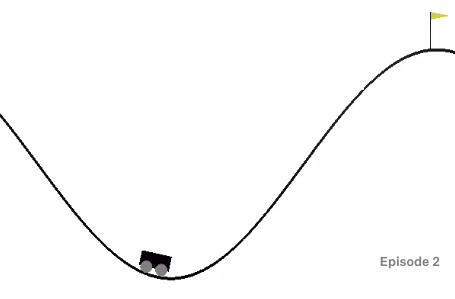

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn.pipeline
import sklearn.preprocessing

from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [3]:
env = gym.envs.make("MountainCarContinuous-v0")
env.observation_space.sample()

array([ 0.34915736, -0.06362072], dtype=float32)

In [4]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=None,
             transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=100,
                                           random_state=None)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=100,
                                           random_state=None)),
                               ('rbf3',
                                RBFSampler(gamma=1.0, n_components=100,
                                           random_state=None)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=100,
                                           random_state=None))],
             transformer_weights=None, verbose=False)

In [5]:
def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

## Recall the Update Rule for Actor

$$\theta_{t+1} \doteq \theta_t + \alpha (r_{t+1} + \gamma v(S_{t+1},w) - v(S_{t},w)) \nabla_\theta \log\pi(A_t|S_t,\theta) $$

In [6]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            
            self.normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma)
            self.action = self.normal_dist._sample_n(1)
            self.action = tf.clip_by_value(self.action, env.action_space.low[0], env.action_space.high[0])

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.action) * self.target
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.action, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [7]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [8]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # env.render()
            
            # Take a step
            action = estimator_policy.predict(state)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [9]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need varies
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is happening there.
    stats = actor_critic(env, policy_estimator, value_estimator, 50, discount_factor=0.95)

Step 825 @ Episode 50/50 (43.13643622148356)

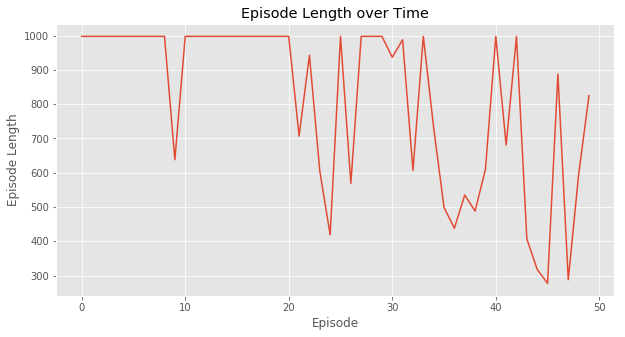

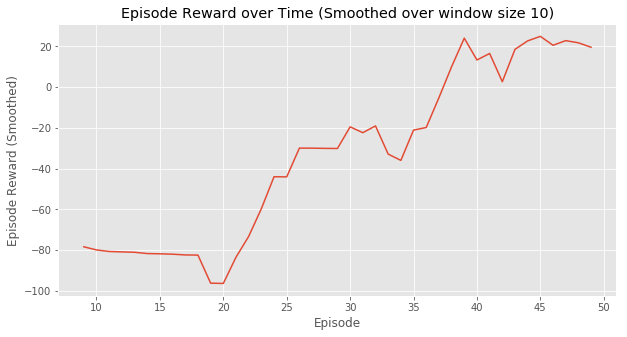

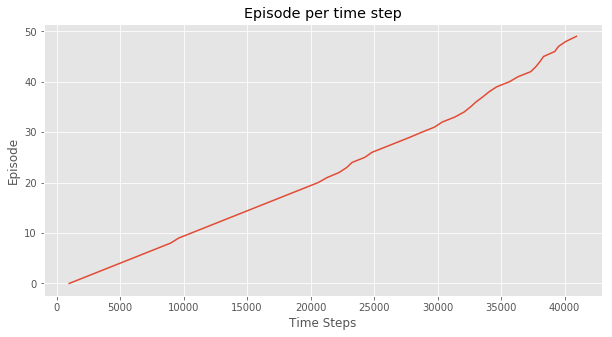

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [10]:
plot_episode_stats(stats, smoothing_window=10)

## Appendix: Proof of Policy Gradient Theorem

http://incompleteideas.net/book/bookdraft2017nov5.pdf Page 268-269

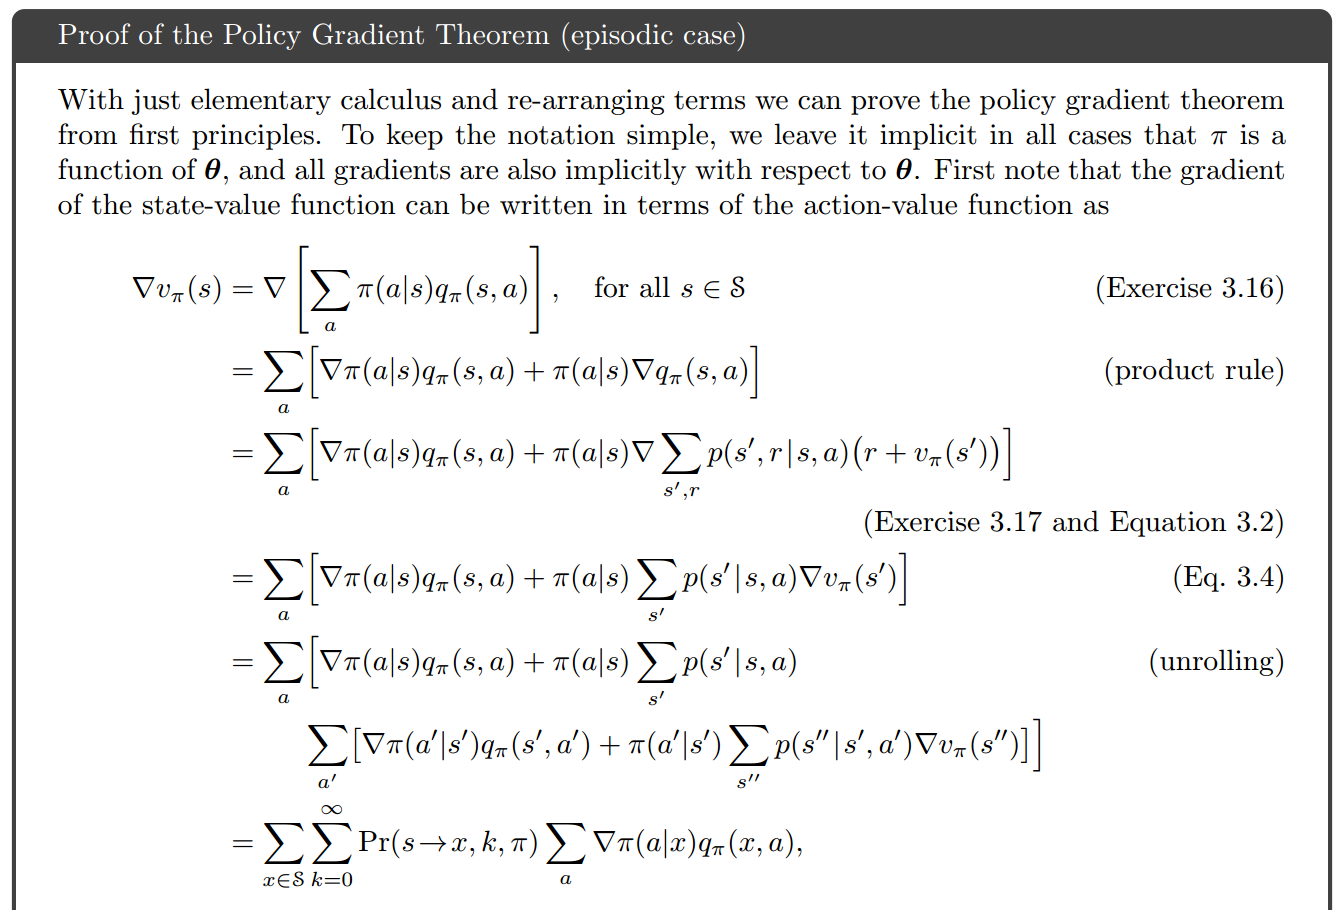

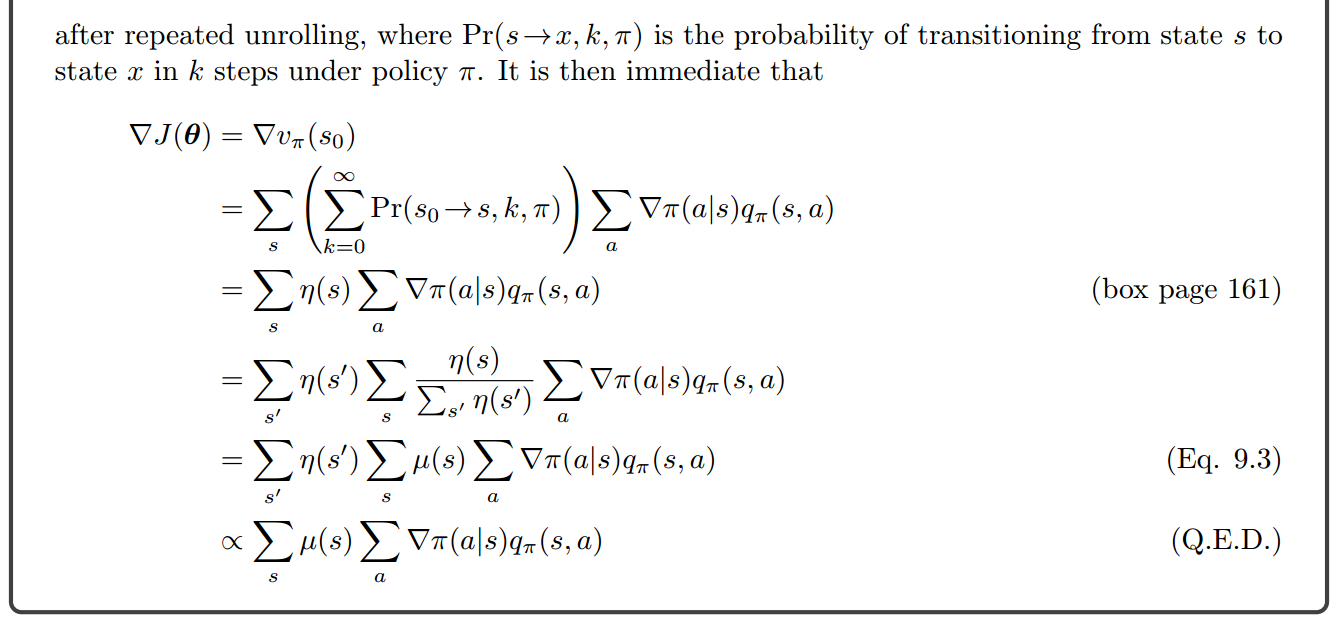